In [1]:
import numpy as np
import pandas as pd
import multiprocessing as mp
import datetime as dt
import math
import os
import gc
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from imblearn.over_sampling import SMOTE

import xgboost as xgb

import gensim.models.doc2vec as d2v

from random import shuffle

from scipy.spatial.distance import cosine

gc.collect()

TRAIN = pd.read_csv('train.csv')
TRAIN.head()

C:\Users\USER\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [2]:
TRAIN.tail()

,id,qid1,qid2,question1,question2,is_duplicate
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0
404289,404289,537932,537933,What is like to have sex with cousin?,What is it like to have sex with your cousin?,0


Number of total questions:    537933
Number of unique questions:   426153
Number of repeated questions: 111780

Percent unique: 0.79%


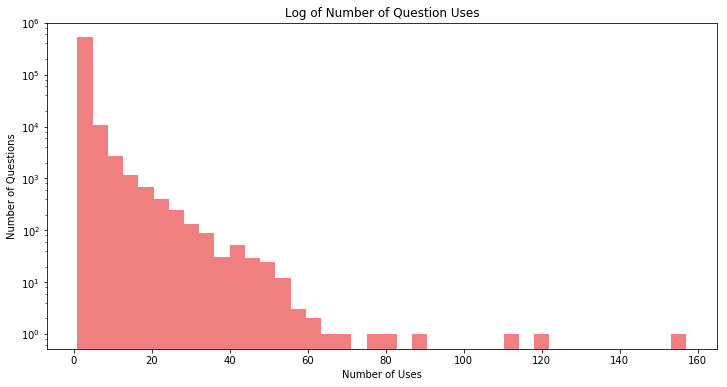

In [2]:
qid = TRAIN.qid1.tolist() + TRAIN.qid2.tolist()
qid_dict = dict.fromkeys(qid, 0)

for x in qid:
    qid_dict[x] += 1

unique = 0
for x in qid_dict:
    if qid_dict[x] == 1:
        unique += 1

total = len(qid_dict)
non_unique = total - unique

print('Number of total questions: '.ljust(30) + str(total))
print('Number of unique questions: '.ljust(30) + str(unique))
print('Number of repeated questions: '.ljust(30) + str(non_unique))
print('\nPercent unique: ' + '{0:.2f}%'.format(unique / total))

plt.figure(figsize=(12, 6))
plt.hist(pd.Series(qid).value_counts(), bins=40, log=True, color='lightcoral', label='train')
plt.xlabel('Number of Uses')
plt.ylabel('Number of Questions')
plt.title('Log of Number of Question Uses')
plt.show()

del qid, qid_dict, unique, total, non_unique

Number of question pairs:     404290
Number of duplicates:         149263
Number of non-duplicates:     255027


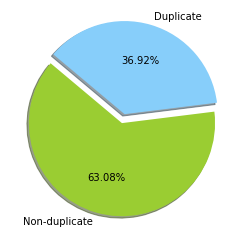

In [3]:
print('Number of question pairs: '.ljust(30) + str(len(TRAIN)))
print('Number of duplicates: '.ljust(30) + str(len(TRAIN[TRAIN.is_duplicate == 1])))
print('Number of non-duplicates: '.ljust(30) + str(len(TRAIN[TRAIN.is_duplicate == 0])))

plt.figure(figsize=(4, 4))
plt.pie(TRAIN.is_duplicate.value_counts(), explode=(0.1, 0), labels=('Non-duplicate', 'Duplicate'), colors=('yellowgreen', 'lightskyblue'), autopct='%1.2f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

In [4]:
TEST = pd.read_csv('test.csv')
TEST.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [5]:
TEST.tail()

,test_id,question1,question2
2345791,2345791,How do Peaks (TV series): Why did Leland kill ...,What is the most study scene in twin peaks?
2345792,2345792,"What does be ""in transit"" mean on FedEx tracking?",How question FedEx packages delivered?
2345793,2345793,What are some famous Romanian drinks (alcoholi...,Can a non-alcoholic restaurant be a huge success?
2345794,2345794,What were the best and worst things about publ...,What are the best and worst things examination...
2345795,2345795,What is the best medication equation erectile ...,How do I out get rid of Erectile Dysfunction?


In [6]:
train_questions = TRAIN.question1.tolist() + TRAIN.question2.tolist()
test_questions = TEST.question1.tolist() + TEST.question2.tolist()

In [7]:
print('Train')
print('-----')
print('Question 1:'.ljust(30) + str(TRAIN.question1.isnull().sum()))
print('Question 2:'.ljust(30) + str(TRAIN.question2.isnull().sum()))
print('\nTest')
print('----')
print('Question 1:'.ljust(30) + str(TEST.question1.isnull().sum()))
print('Question 2:'.ljust(30) + str(TEST.question2.isnull().sum()))

Train
-----
Question 1:                   0
Question 2:                   2

Test
----
Question 1:                   2
Question 2:                   4



Train Statistics
----------------
count    808580.000000
mean         11.064856
std           5.889168
min           1.000000
25%           7.000000
50%          10.000000
75%          13.000000
max         237.000000
dtype: float64

Test Statistics
---------------
count    4.691592e+06
mean     1.102431e+01
std      5.839925e+00
min      1.000000e+00
25%      7.000000e+00
50%      1.000000e+01
75%      1.300000e+01
max      2.380000e+02
dtype: float64


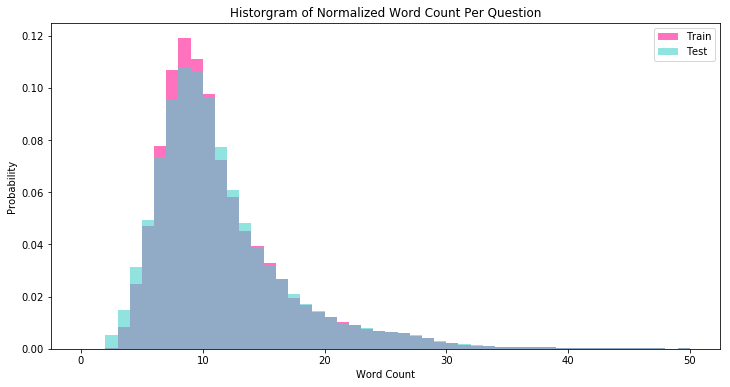

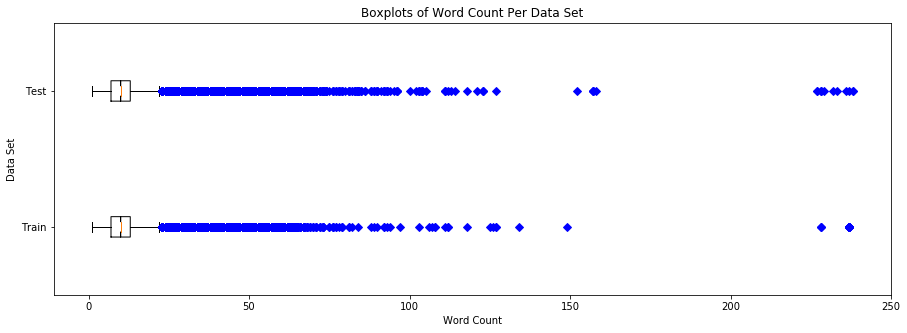

In [8]:
train_word_counts = pd.Series([len(str(x).split(' ')) for x in train_questions])
test_word_counts = pd.Series([len(str(x).split(' ')) for x in test_questions])

print('\nTrain Statistics')
print('----------------')
print(train_word_counts.describe())
print('\nTest Statistics')
print('---------------')
print(test_word_counts.describe())

plt.figure(figsize=(12,6))
plt.hist(train_word_counts, bins=50, range=[0, 50], color=('deeppink'), normed=True, alpha=0.6, label='Train')
plt.hist(test_word_counts, bins=50, range=[0, 50], color=('mediumturquoise'), normed=True, alpha=0.6, label='Test')
plt.xlabel('Word Count')
plt.ylabel('Probability')
plt.title('Historgram of Normalized Word Count Per Question')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.boxplot([train_word_counts, test_word_counts], True, 'bD', vert=False, labels=('Train', 'Test'))
plt.xlabel('Word Count')
plt.ylabel('Data Set')
plt.title('Boxplots of Word Count Per Data Set')
plt.show()


TRAIN Statistics:
-----------------
count    808580.000000
mean         59.822548
std          31.963751
min           1.000000
25%          39.000000
50%          51.000000
75%          72.000000
max        1169.000000
dtype: float64

TEST Statistics:
----------------
count    4.691592e+06
mean     6.007010e+01
std      3.162463e+01
min      1.000000e+00
25%      4.000000e+01
50%      5.300000e+01
75%      7.200000e+01
max      1.176000e+03
dtype: float64


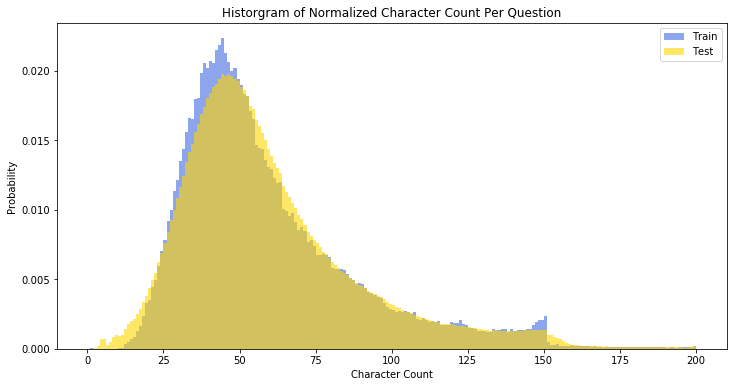

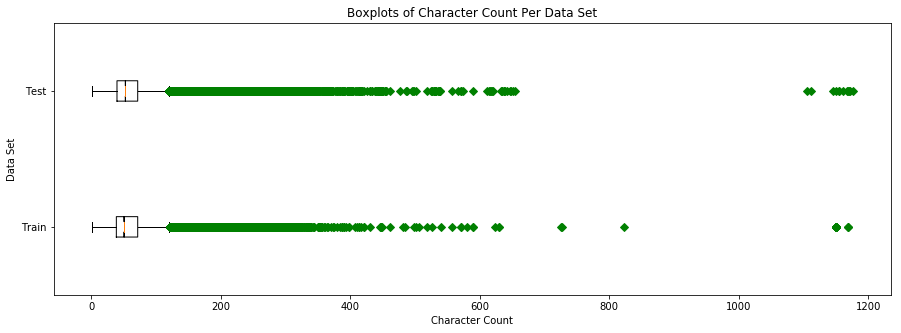

In [9]:
train_char_counts = pd.Series([len(str(x))for x in train_questions])
test_char_counts = pd.Series([len(str(x)) for x in test_questions])

print('\nTRAIN Statistics:')
print('-----------------')
print(train_char_counts.describe())
print('\nTEST Statistics:')
print('----------------')
print(test_char_counts.describe())

plt.figure(figsize=(12,6))
plt.hist(train_char_counts, bins=200, range=[0, 200], color=('royalblue'), normed=True, alpha=0.6, label='Train')
plt.hist(test_char_counts, bins=200, range=[0, 200], color=('gold'), normed=True, alpha=0.6, label='Test')
plt.xlabel('Character Count')
plt.ylabel('Probability')
plt.title('Historgram of Normalized Character Count Per Question')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.boxplot([train_char_counts, test_char_counts], True, 'gD', vert=False, labels=('Train', 'Test'))
plt.xlabel('Character Count')
plt.ylabel('Data Set')
plt.title('Boxplots of Character Count Per Data Set')
plt.show()

In [10]:
del train_questions, test_questions, train_word_counts, test_word_counts, train_char_counts, test_char_counts
gc.collect()

64049

In [12]:
# Tokenizing
tokenizer = RegexpTokenizer(r'\w+')
df = TRAIN.question1.append(TRAIN.question2).apply(lambda x: tokenizer.tokenize(str(x).lower()))

In [13]:
df.to_pickle('TRAIN_tokenized.pkl')

In [14]:
del tokenizer, df

In [22]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [17]:
# Stopword filtering
stopset = set(stopwords.words('english'))


In [18]:
# Train
df = pd.read_pickle('TRAIN_tokenized.pkl')
df = df.apply(lambda x: [w for w in x if w not in stopset])
df.to_pickle('TRAIN_filtered.pkl')

# Test
#df = pd.read_pickle('./pickles.gi/TEST_tokenized.pkl')
#df = df.apply(lambda x: [w for w in x if w not in stopset])
#df.to_pickle('./pickles.gi/TEST_filtered.pkl')

del stopset, df

In [19]:
# Stemming (with and without stopword filtering)
stemmer = SnowballStemmer('english')

# Train - No filtering
df = pd.read_pickle('TRAIN_tokenized.pkl')
df = df.apply(lambda x: [stemmer.stem(w) for w in x])
df.to_pickle('TRAIN_stemmed.pkl')

# Train - Filtering
df = pd.read_pickle('TRAIN_filtered.pkl')
df = df.apply(lambda x: [stemmer.stem(w) for w in x])
df.to_pickle('TRAIN_stemmed_filtered.pkl')

# Test - No filtering
#df = pd.read_pickle('./pickles.gi/TEST_tokenized.pkl')
#df = df.apply(lambda x: [stemmer.stem(w) for w in x])
#df.to_pickle('./pickles.gi/TEST_stemmed.pkl')

# Test - Filtering
#df = pd.read_pickle('./pickles.gi/TEST_filtered.pkl')
#df = df.apply(lambda x: [stemmer.stem(w) for w in x])
#df.to_pickle('./pickles.gi/TEST_stemmed_filtered.pkl')

del df, stemmer

In [27]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [20]:
# Lemmatizing (with and without stopword filtering)
lemmatizer = WordNetLemmatizer()

# Train - No filtering
df = pd.read_pickle('TRAIN_tokenized.pkl')
df = df.apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
df.to_pickle('TRAIN_lemmatized.pkl')

# Train - Filtering
df = pd.read_pickle('TRAIN_filtered.pkl')
df = df.apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
df.to_pickle('TRAIN_lemmatized_filtered.pkl')

# Test - No filtering
#df = pd.read_pickle('./pickles.gi/TEST_tokenized.pkl')
#df = df.apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
#df.to_pickle('./pickles.gi/TEST_lemmatized.pkl')

# Test - Filtering
#df = pd.read_pickle('./pickles.gi/TEST_filtered.pkl')
#df = df.apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
#df.to_pickle('./pickles.gi/TEST_lemmatized_filtered.pkl')

del df, lemmatizer

In [46]:
# Tagging for Doc2Vec processing
df = pd.DataFrame()

# Train
preprocessed_stacked = pd.read_pickle('TRAIN_preprocessed_stacked.pkl')
df['pid'] = preprocessed_stacked.pid
df['qid'] = preprocessed_stacked.qid
df['base'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['base'], [x['qid']]), axis=1)
df['filtered'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['filtered'], [x['qid']]), axis=1)
df['stemmed'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['stemmed'], [x['qid']]), axis=1)
df['stemmed_filtered'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['stemmed_filtered'], [x['qid']]), axis=1)
df['lemmatized'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['lemmatized'], [x['qid']]), axis=1)
df['lemmatized_filtered'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['lemmatized_filtered'], [x['qid']]), axis=1)
df.reset_index(drop=True, inplace=True)
df.to_pickle('TRAIN_tagged.pkl')

# Train
#preprocessed_stacked = pd.read_pickle('./pickles.gi/TEST_preprocessed_unstacked.pkl')
#df['pid'] = preprocessed_stacked.pid
#df['qid'] = preprocessed_stacked.qid
#df['base'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['base'], [x['qid']]), axis=1)
#df['filtered'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['filtered'], [x['qid']]), axis=1)
#df['stemmed'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['stemmed'], [x['qid']]), axis=1)
#df['stemmed_filtered'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['stemmed_filtered'], [x['qid']]), axis=1)
#df['lemmatized'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['lemmatized'], [x['qid']]), axis=1)
#df['lemmatized_filtered'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['lemmatized_filtered'], [x['qid']]), axis=1)
#df.reset_index(drop=True, inplace=True)
#df.to_pickle('./pickles.gi/TEST_tagged.pkl')

del df, preprocessed_stacked

In [11]:
def calculate_word_share(q1, q2, tfidf_weights={}):
    if tfidf_weights:
        q1_shared = np.sum([tfidf_weights.get(x, 0) for x in q1 if x in q2])
        q2_shared = np.sum([tfidf_weights.get(x, 0) for x in q2 if x in q1])
        total = np.sum([tfidf_weights.get(x, 0) for x in q1]) + np.sum([tfidf_weights.get(x, 0) for x in q2])
    else:
        q1_shared = len([x for x in q1 if x in q2])
        q2_shared = len([x for x in q2 if x in q1])
        total = len(q1) + len(q2)
    if total == 0:
        return 0
    else:
        return (q1_shared + q2_shared) / total

In [12]:
TRAIN_preprocessed = pd.read_pickle('TRAIN_preprocessed_unstacked.pkl')

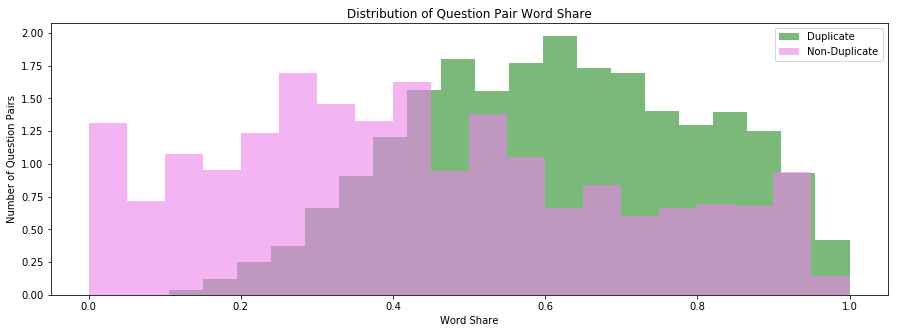

In [23]:
# Base
TRAIN_word_share_base = TRAIN_preprocessed.apply(lambda x: calculate_word_share(x['base_1'], x['base_2']), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(TRAIN_word_share_base[TRAIN.is_duplicate == 1], bins=20, color=('forestgreen'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(TRAIN_word_share_base[TRAIN.is_duplicate == 0], bins=20, color=('violet'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share')
plt.legend()
plt.show()

TRAIN_word_share_base.to_pickle('TRAIN_word_share_base.pkl')

del TRAIN_word_share_base

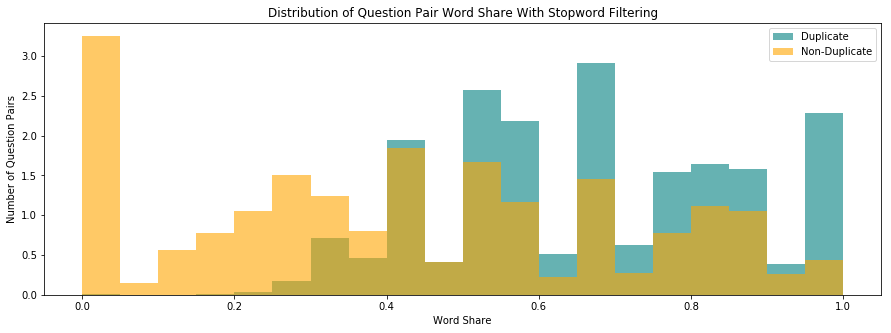

In [24]:
# Stopword filtering
TRAIN_word_share_filtered = TRAIN_preprocessed.apply(lambda x: calculate_word_share(x['filtered_1'], x['filtered_2']), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(TRAIN_word_share_filtered[TRAIN.is_duplicate == 1], bins=20, color=('teal'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(TRAIN_word_share_filtered[TRAIN.is_duplicate == 0], bins=20, color=('orange'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share With Stopword Filtering')
plt.legend()
plt.show()

TRAIN_word_share_filtered.to_pickle('TRAIN_word_share_filtered.pkl')

del TRAIN_word_share_filtered

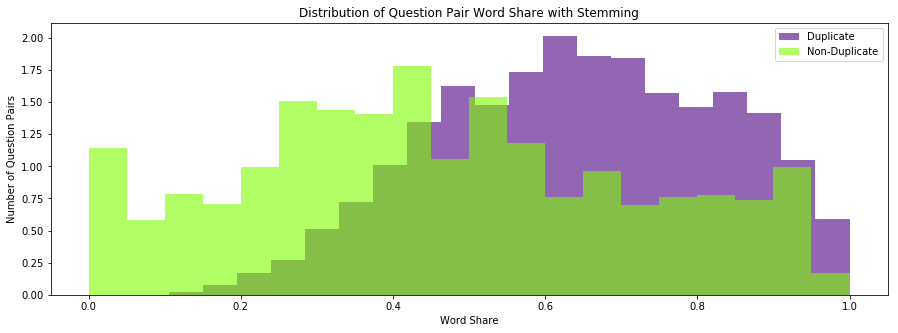

In [25]:
# Stemming
TRAIN_word_share_stemmed = TRAIN_preprocessed.apply(lambda x: calculate_word_share(x['stemmed_1'], x['stemmed_2']), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(TRAIN_word_share_stemmed[TRAIN.is_duplicate == 1], bins=20, color=('indigo'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(TRAIN_word_share_stemmed[TRAIN.is_duplicate == 0], bins=20, color=('lawngreen'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share with Stemming')
plt.legend()
plt.show()

TRAIN_word_share_stemmed.to_pickle('TRAIN_word_share_stemmed.pkl')

del TRAIN_word_share_stemmed

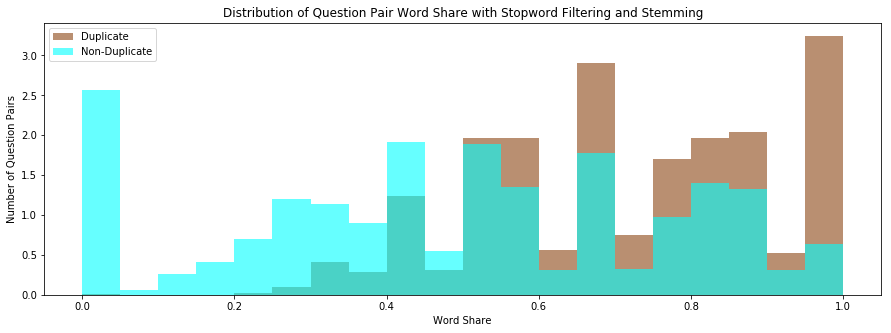

In [26]:
# Stopword filtering and stemming
TRAIN_word_share_stemmed_filtered = TRAIN_preprocessed.apply(lambda x: calculate_word_share(x['stemmed_filtered_1'], x['stemmed_filtered_2']), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(TRAIN_word_share_stemmed_filtered[TRAIN.is_duplicate == 1], bins=20, color=('saddlebrown'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(TRAIN_word_share_stemmed_filtered[TRAIN.is_duplicate == 0], bins=20, color=('cyan'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share with Stopword Filtering and Stemming')
plt.legend()
plt.show()

TRAIN_word_share_stemmed_filtered.to_pickle('TRAIN_word_share_stemmed_filtered.pkl')

del TRAIN_word_share_stemmed_filtered

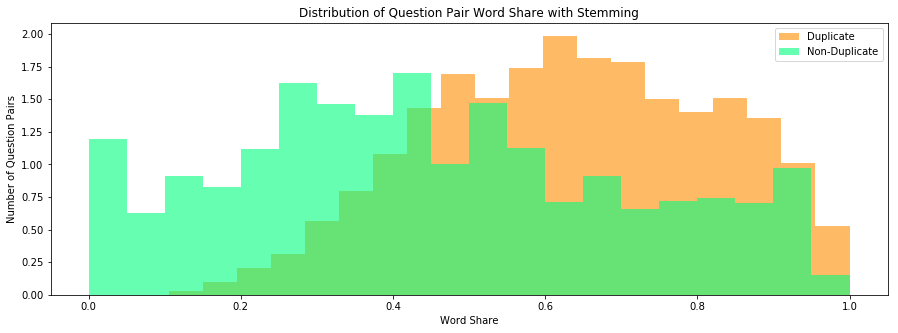

In [27]:
# Lemmatizing
TRAIN_word_share_lemmatized = TRAIN_preprocessed.apply(lambda x: calculate_word_share(x['lemmatized_1'], x['lemmatized_2']), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(TRAIN_word_share_lemmatized[TRAIN.is_duplicate == 1], bins=20, color=('darkorange'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(TRAIN_word_share_lemmatized[TRAIN.is_duplicate == 0], bins=20, color=('springgreen'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share with Stemming')
plt.legend()
plt.show()

TRAIN_word_share_lemmatized.to_pickle('TRAIN_word_share_lemmatized.pkl')

del TRAIN_word_share_lemmatized

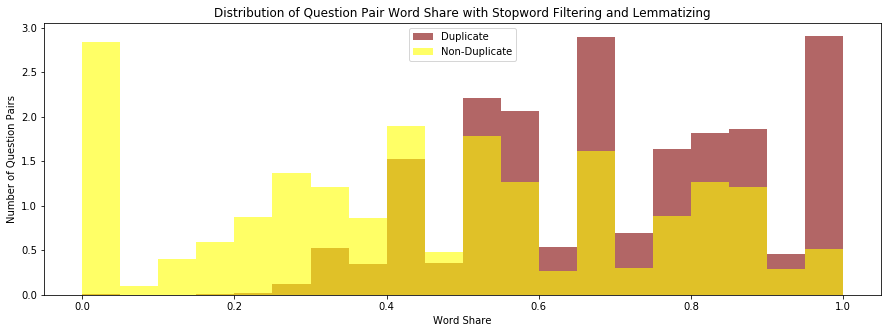

In [28]:
# Stopword filtering and lemmatizing
TRAIN_word_share_lemmatized_filtered = TRAIN_preprocessed.apply(lambda x: calculate_word_share(x['lemmatized_filtered_1'], x['lemmatized_filtered_2']), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(TRAIN_word_share_lemmatized_filtered[TRAIN.is_duplicate == 1], bins=20, color=('maroon'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(TRAIN_word_share_lemmatized_filtered[TRAIN.is_duplicate == 0], bins=20, color=('yellow'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share with Stopword Filtering and Lemmatizing')
plt.legend()
plt.show()

TRAIN_word_share_lemmatized_filtered.to_pickle('TRAIN_word_share_lemmatized_filtered.pkl')

del TRAIN_word_share_lemmatized_filtered

In [30]:
# Combine metrics into single dataframe
df = pd.DataFrame()
df['pid'] = TRAIN_preprocessed.pid
df['base'] = pd.read_pickle('TRAIN_word_share_base.pkl')
df['filtered'] = pd.read_pickle('TRAIN_word_share_filtered.pkl')
df['stemmed'] = pd.read_pickle('TRAIN_word_share_stemmed.pkl')
df['stemmed_filtered'] = pd.read_pickle('TRAIN_word_share_stemmed_filtered.pkl')
df['lemmatized'] = pd.read_pickle('TRAIN_word_share_lemmatized.pkl')
df['lemmatized_filtered'] = pd.read_pickle('TRAIN_word_share_lemmatized_filtered.pkl')
df.to_pickle('TRAIN_word_share.pkl')

del df, TRAIN_preprocessed

In [13]:
TRAIN_preprocessed_stacked = pd.read_pickle('TRAIN_preprocessed_stacked.pkl')
vectorizer = TfidfVectorizer()

# Base
TDX = vectorizer.fit_transform(TRAIN_preprocessed_stacked.base.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('TRAIN_tfidf_weights_base.pkl', 'wb'))

# Filtered
TDX = vectorizer.fit_transform(TRAIN_preprocessed_stacked.filtered.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('TRAIN_tfidf_weights_filtered.pkl', 'wb'))

# Stemmed
TDX = vectorizer.fit_transform(TRAIN_preprocessed_stacked.stemmed.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('TRAIN_tfidf_weights_stemmed.pkl', 'wb'))

# Stemmed & Filtered
TDX = vectorizer.fit_transform(TRAIN_preprocessed_stacked.stemmed_filtered.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('TRAIN_tfidf_weights_stemmed_filtered.pkl', 'wb'))

# Lemmatized
TDX = vectorizer.fit_transform(TRAIN_preprocessed_stacked.lemmatized.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('TRAIN_tfidf_weights_lemmatized.pkl', 'wb'))

# Lemmatized & Filtered
TDX = vectorizer.fit_transform(TRAIN_preprocessed_stacked.lemmatized_filtered.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('TRAIN_tfidf_weights_lemmatized_filtered.pkl', 'wb'))

del TRAIN_preprocessed_stacked, vectorizer, TDX, weights

In [14]:
TRAIN_preprocessed_unstacked = pd.read_pickle('TRAIN_preprocessed_unstacked.pkl')

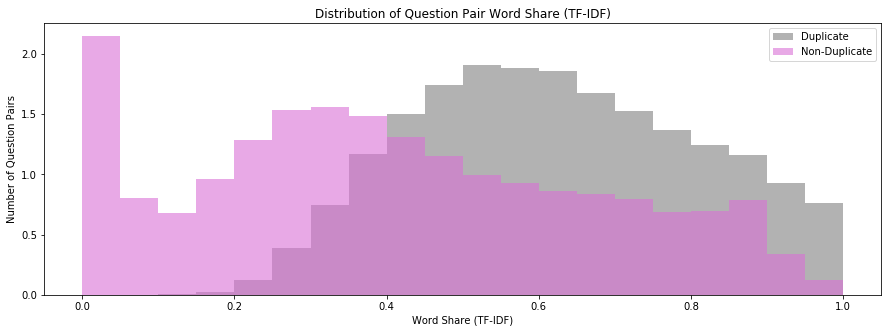

In [34]:
weights = pickle.load(open('TRAIN_tfidf_weights_base.pkl', 'rb'))
TRAIN_tfidf_word_share_base = TRAIN_preprocessed_unstacked.apply(lambda x: calculate_word_share(x['base_1'], x['base_2'], weights), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(TRAIN_tfidf_word_share_base[TRAIN.is_duplicate == 1], bins=20, color=('gray'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(TRAIN_tfidf_word_share_base[TRAIN.is_duplicate == 0], bins=20, color=('orchid'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share (TF-IDF)')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share (TF-IDF)')
plt.legend()
plt.show()

TRAIN_tfidf_word_share_base.to_pickle('TRAIN_tfidf_word_share_base.pkl')

del weights, TRAIN_tfidf_word_share_base

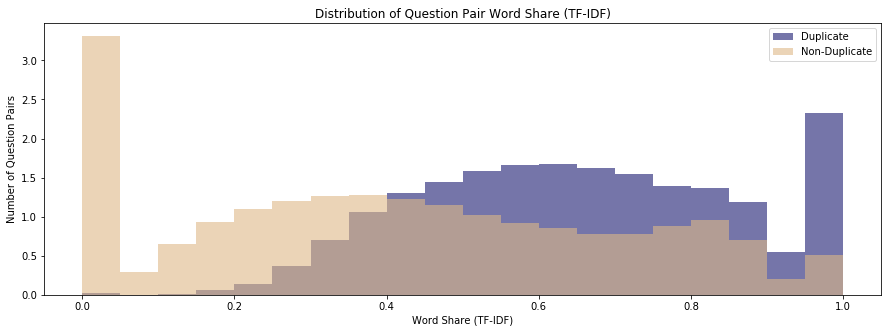

In [35]:
weights = pickle.load(open('TRAIN_tfidf_weights_filtered.pkl', 'rb'))
TRAIN_tfidf_word_share_filtered = TRAIN_preprocessed_unstacked.apply(lambda x: calculate_word_share(x['filtered_1'], x['filtered_2'], weights), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(TRAIN_tfidf_word_share_filtered[TRAIN.is_duplicate == 1], bins=20, color=('midnightblue'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(TRAIN_tfidf_word_share_filtered[TRAIN.is_duplicate == 0], bins=20, color=('burlywood'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share (TF-IDF)')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share (TF-IDF)')
plt.legend()
plt.show()

TRAIN_tfidf_word_share_filtered.to_pickle('TRAIN_tfidf_word_share_filtered.pkl')

del weights, TRAIN_tfidf_word_share_filtered

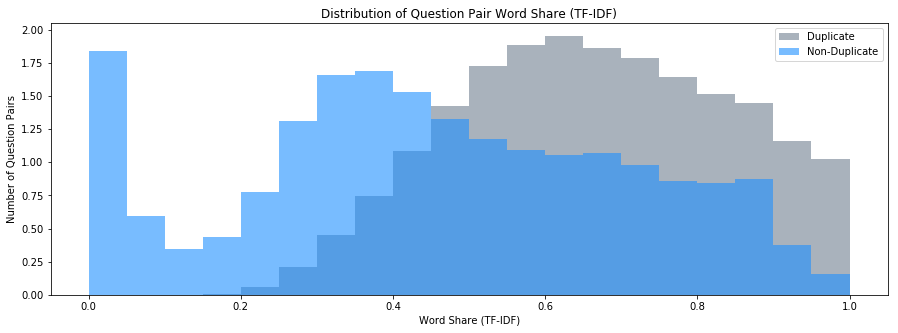

In [36]:
weights = pickle.load(open('TRAIN_tfidf_weights_stemmed.pkl', 'rb'))
TRAIN_tfidf_word_share_stemmed = TRAIN_preprocessed_unstacked.apply(lambda x: calculate_word_share(x['stemmed_1'], x['stemmed_2'], weights), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(TRAIN_tfidf_word_share_stemmed[TRAIN.is_duplicate == 1], bins=20, color=('slategray'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(TRAIN_tfidf_word_share_stemmed[TRAIN.is_duplicate == 0], bins=20, color=('dodgerblue'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share (TF-IDF)')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share (TF-IDF)')
plt.legend()
plt.show()

TRAIN_tfidf_word_share_stemmed.to_pickle('TRAIN_tfidf_word_share_stemmed.pkl')

del weights, TRAIN_tfidf_word_share_stemmed

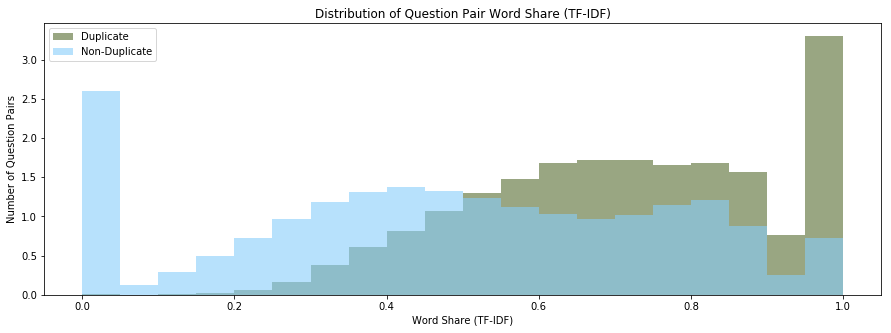

In [37]:
weights = pickle.load(open('TRAIN_tfidf_weights_stemmed_filtered.pkl', 'rb'))
TRAIN_tfidf_word_share_stemmed_filtered = TRAIN_preprocessed_unstacked.apply(lambda x: calculate_word_share(x['stemmed_filtered_1'], x['stemmed_filtered_2'], weights), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(TRAIN_tfidf_word_share_stemmed_filtered[TRAIN.is_duplicate == 1], bins=20, color=('darkolivegreen'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(TRAIN_tfidf_word_share_stemmed_filtered[TRAIN.is_duplicate == 0], bins=20, color=('lightskyblue'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share (TF-IDF)')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share (TF-IDF)')
plt.legend()
plt.show()

TRAIN_tfidf_word_share_stemmed_filtered.to_pickle('TRAIN_tfidf_word_share_stemmed_filtered.pkl')

del weights, TRAIN_tfidf_word_share_stemmed_filtered

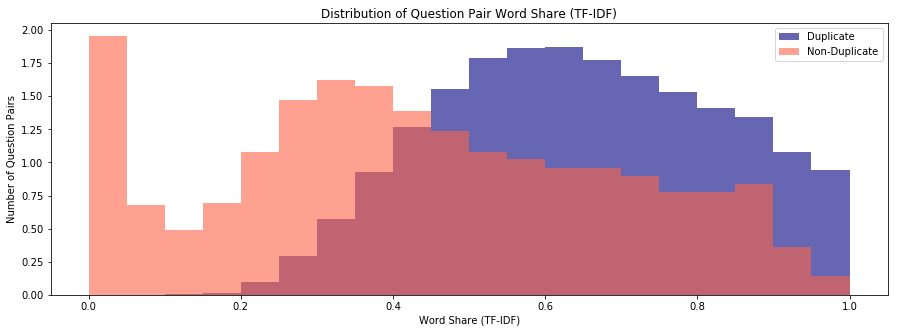

In [38]:
weights = pickle.load(open('TRAIN_tfidf_weights_lemmatized.pkl', 'rb'))
TRAIN_tfidf_word_share_lemmatized = TRAIN_preprocessed_unstacked.apply(lambda x: calculate_word_share(x['lemmatized_1'], x['lemmatized_2'], weights), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(TRAIN_tfidf_word_share_lemmatized[TRAIN.is_duplicate == 1], bins=20, color=('navy'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(TRAIN_tfidf_word_share_lemmatized[TRAIN.is_duplicate == 0], bins=20, color=('tomato'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share (TF-IDF)')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share (TF-IDF)')
plt.legend()
plt.show()

TRAIN_tfidf_word_share_lemmatized.to_pickle('TRAIN_tfidf_word_share_lemmatized.pkl')

del weights, TRAIN_tfidf_word_share_lemmatized

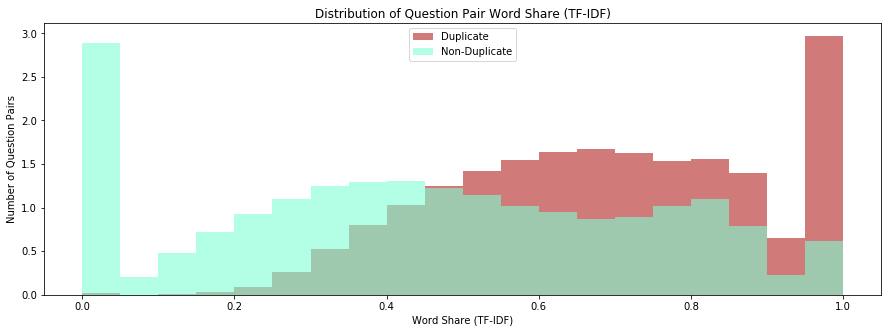

In [39]:
weights = pickle.load(open('TRAIN_tfidf_weights_lemmatized_filtered.pkl', 'rb'))
TRAIN_tfidf_word_share_lemmatized_filtered = TRAIN_preprocessed_unstacked.apply(lambda x: calculate_word_share(x['lemmatized_filtered_1'], x['lemmatized_filtered_2'], weights), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(TRAIN_tfidf_word_share_lemmatized_filtered[TRAIN.is_duplicate == 1], bins=20, color=('firebrick'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(TRAIN_tfidf_word_share_lemmatized_filtered[TRAIN.is_duplicate == 0], bins=20, color=('aquamarine'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share (TF-IDF)')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share (TF-IDF)')
plt.legend()
plt.show()

TRAIN_tfidf_word_share_lemmatized_filtered.to_pickle('TRAIN_tfidf_word_share_lemmatized_filtered.pkl')

del weights, TRAIN_tfidf_word_share_lemmatized_filtered

In [40]:
# Combine metrics into single dataframe
df = pd.DataFrame()
df['pid'] = TRAIN_preprocessed_unstacked.pid
df['base'] = pd.read_pickle('TRAIN_tfidf_word_share_base.pkl')
df['filtered'] = pd.read_pickle('TRAIN_tfidf_word_share_filtered.pkl')
df['stemmed'] = pd.read_pickle('TRAIN_tfidf_word_share_stemmed.pkl')
df['stemmed_filtered'] = pd.read_pickle('TRAIN_tfidf_word_share_stemmed_filtered.pkl')
df['lemmatized'] = pd.read_pickle('TRAIN_tfidf_word_share_lemmatized.pkl')
df['lemmatized_filtered'] = pd.read_pickle('TRAIN_tfidf_word_share_lemmatized_filtered.pkl')
df.to_pickle('TRAIN_tfidf_word_share.pkl')

del df, TRAIN_preprocessed_unstacked

In [16]:
del TRAIN_preprocessed_unstacked

In [17]:
TRAIN_word_share = pd.read_pickle('TRAIN_word_share.pkl')
TRAIN_tfidf_word_share = pd.read_pickle('TRAIN_tfidf_word_share.pkl')

print('Word Share Proportion')
print('---------------------')
print('Base:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, TRAIN_word_share.base))
print('Filtered:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, TRAIN_word_share.filtered))
print('Stemmed:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, TRAIN_word_share.stemmed))
print('Stemmed & Filtered:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, TRAIN_word_share.stemmed_filtered))
print('Lemmatized:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, TRAIN_word_share.lemmatized))
print('Lemmatized & Filtered:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, TRAIN_word_share.lemmatized_filtered))
print('\nTF-IDF Weighting')
print('----------------')
print('Base:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, TRAIN_tfidf_word_share.base))
print('Filtered:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, TRAIN_tfidf_word_share.filtered))
print('Stemmed:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, TRAIN_tfidf_word_share.stemmed))
print('Stemmed & Filtered:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, TRAIN_tfidf_word_share.stemmed_filtered))
print('Lemmatized:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, TRAIN_tfidf_word_share.lemmatized))
print('Lemmatized & Filtered:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, TRAIN_tfidf_word_share.lemmatized_filtered))

del TRAIN_word_share, TRAIN_tfidf_word_share

Word Share Proportion
---------------------
Base:                          0.717529896461
Filtered:                      0.743939809911
Stemmed:                       0.713523771993
Stemmed & Filtered:            0.737908827868
Lemmatized:                    0.716489894896
Lemmatized & Filtered:         0.743030404891

TF-IDF Weighting
----------------
Base:                          0.740072079517
Filtered:                      0.741688823416
Stemmed:                       0.735719806883
Stemmed & Filtered:            0.739308876228
Lemmatized:                    0.739323070552
Lemmatized & Filtered:         0.742681743386


In [18]:
# Multicore
cores = mp.cpu_count() - 1
assert d2v.FAST_VERSION > -1, "Doc2Vec will run painfully slow otherwise"

# Get doc list
tagged_docs = pd.read_pickle('TRAIN_tagged.pkl')
doc_list = tagged_docs.lemmatized_filtered.tolist()

# Build Model: PV-DM w/average
dmm_model = d2v.Doc2Vec(dm=1, dm_mean=1, size=300, window=5, negative=5, hs=0, min_count=2, workers=cores)

train_model = dmm_model

# Train model
alpha, min_alpha, passes = (0.025, 0.001, 10)
alpha_delta = (alpha - min_alpha) / passes

# Build vocab table
train_model.build_vocab(doc_list)

# Get pretrained word2vec weights where possible
train_model.intersect_word2vec_format('./word2vec.gi/GoogleNews-vectors-negative300.bin', binary=True)

print("START %s" % dt.datetime.now())

for epoch in range(passes):
    # shuffling gets best results
    shuffle(doc_list)

    print ('Training epoch %s' % epoch)

    # train
    train_model.alpha, train_model.min_alpha = alpha, alpha
    train_model.train(doc_list)

    print('completed pass %i at alpha %f' % (epoch + 1, alpha))
    print(str(dt.datetime.now()))
    
    alpha -= alpha_delta

train_model.save('dmm_model_lemmatized_filtered_word2vec_size300_iter10')

print("END %s" % str(dt.datetime.now()))

del cores, tagged_docs, dmm_model, doc_list, alpha, min_alpha, passes, alpha_delta, train_model

C:\Users\USER\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\gensim\models\doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


TypeError: build_vocab() missing 1 required positional argument: 'documents'

In [20]:
# Build vocab table
train_model.build_vocab(doc_list)

# Get pretrained word2vec weights where possible
train_model.intersect_word2vec_format('./word2vec.gi/GoogleNews-vectors-negative300.bin', binary=True)

print("START %s" % dt.datetime.now())

for epoch in range(passes):
    # shuffling gets best results
    shuffle(doc_list)

    print ('Training epoch %s' % epoch)

    # train
    train_model.alpha, train_model.min_alpha = alpha, alpha
    train_model.train(doc_list)

    print('completed pass %i at alpha %f' % (epoch + 1, alpha))
    print(str(dt.datetime.now()))
    
    alpha -= alpha_delta

train_model.save('./models.gi/dmm_model_lemmatized_filtered_word2vec_size300_iter10')

print("END %s" % str(dt.datetime.now()))

del cores, tagged_docs, dmm_model, doc_list, alpha, min_alpha, passes, alpha_delta, train_model

RuntimeError: cannot sort vocabulary after model weights already initialized.

In [44]:
TRAIN_word_share = pd.read_pickle('TRAIN_word_share.pkl')
TRAIN_tfidf_word_share = pd.read_pickle('TRAIN_tfidf_word_share.pkl')
TRAIN_d2v_cos_sim = pd.read_pickle('TRAIN_d2v_cos_sim.pkl')

X_train = pd.DataFrame()
X_train['word_share_base'] = TRAIN_word_share.base
X_train['word_share_filtered'] = TRAIN_word_share.filtered
X_train['word_share_stemmed'] = TRAIN_word_share.stemmed
X_train['word_share_stemmed_filtered'] = TRAIN_word_share.stemmed_filtered
X_train['word_share_lemmatized'] = TRAIN_word_share.lemmatized
X_train['word_share_lemmatized_filtered'] = TRAIN_word_share.lemmatized
X_train['tfidf_word_share_base'] = TRAIN_tfidf_word_share.base
X_train['tfidf_word_share_filtered'] = TRAIN_tfidf_word_share.filtered
X_train['tfidf_word_share_stemmed'] = TRAIN_tfidf_word_share.stemmed
X_train['tfidf_word_share_stemmed_filtered'] = TRAIN_tfidf_word_share.stemmed_filtered
X_train['tfidf_word_share_lemmatized'] = TRAIN_tfidf_word_share.lemmatized
X_train['tfidf_word_share_lemmatized_filtered'] = TRAIN_tfidf_word_share.lemmatized_filtered
X_train['d2v_cos_sim_lemmatized_filtered'] = TRAIN_d2v_cos_sim.lemmatized_filtered

y_train = TRAIN.is_duplicate.values

del TRAIN_word_share, TRAIN_tfidf_word_share, TRAIN_d2v_cos_sim

FileNotFoundError: [Errno 2] No such file or directory: 'TRAIN_d2v_cos_sim.pkl'

In [45]:
cores = mp.cpu_count() - 1

params = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,10,2)
}

xgb_model = xgb.XGBClassifier(
 learning_rate=0.1,
 n_estimators=1000,
 objective= 'binary:logistic',
 scale_pos_weight=1,
 seed=27)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='neg_log_loss', cv=4, verbose=10)

grid_search.fit(X_training, y_training)

grid_search.grid_scores_, grid_search.best_params_, grid_search.best_score_

NameError: name 'X_training' is not defined

In [ ]:

gpu_paramsgpu_para  = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.01,
    'max_depth': 9,
    'min_child_weight': 1,
    'updater': 'grow_gpu',
    'n_estimators': 1000,
    'scale_pos_weight': 1
}

D_training = xgb.DMatrix(X_training_pruned, label=y_training)
D_validation = xgb.DMatrix(X_validation_pruned, label=y_validation)
watchlist = [(D_training, 'training'), (D_validation, 'validation')]

bst = xgb.train(gpu_params, D_training, 50000, watchlist, early_stopping_rounds=10000, verbose_eval=50)

In [ ]:
# Combine preprocessed text into a stacked dataframe
df = pd.DataFrame()
df['pid'] = TEST.test_id.append(TEST.test_id)
df['qid'] = pd.Series(np.arange(len(TEST) * 2))
df['base'] = pd.read_pickle('./pickles.gi/TEST_tokenized.pkl')
df['filtered'] = pd.read_pickle('./pickles.gi/TEST_filtered.pkl')
df['stemmed'] = pd.read_pickle('./pickles.gi/TEST_stemmed.pkl')
df['stemmed_filtered'] = pd.read_pickle('./pickles.gi/TEST_stemmed_filtered.pkl')
df['lemmatized'] = pd.read_pickle('./pickles.gi/TEST_lemmatized.pkl')
df['lemmatized_filtered'] = pd.read_pickle('./pickles.gi/TEST_lemmatized_filtered.pkl')
df.to_pickle('./pickles.gi/TEST_preprocessed_stacked.pkl')

# Create unstacked version of preprocessed dataframe
df = pd.read_pickle('./pickles.gi/TEST_preprocessed_stacked.pkl')
df = df.merge(df, how='inner', on='pid', suffixes=('_1','_2'))
df = df[(df['qid_1'] != df['qid_2']) & (df['qid_1'] < df['qid_1'])]
df.reset_index(drop=True, inplace=True)
df.to_pickle('./pickles.gi/TEST_preprocessed_unstacked.pkl')

# Tagging for Doc2Vec processing
preprocessed_stacked = pd.read_pickle('./pickles.gi/TEST_preprocessed_unstacked.pkl')
df = pd.DataFrame()
df['pid'] = preprocessed_stacked.pid
df['qid'] = preprocessed_stacked.qid
df['base'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['base'], [x['qid']]), axis=1)
df['filtered'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['filtered'], [x['qid']]), axis=1)
df['stemmed'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['stemmed'], [x['qid']]), axis=1)
df['stemmed_filtered'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['stemmed_filtered'], [x['qid']]), axis=1)
df['lemmatized'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['lemmatized'], [x['qid']]), axis=1)
df['lemmatized_filtered'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['lemmatized_filtered'], [x['qid']]), axis=1)
df.reset_index(drop=True, inplace=True)
df.to_pickle('./pickles.gi/TEST_tagged.pkl')

In [ ]:
# Word share
TEST_word_share_base = TEST_preprocessed.apply(lambda x: calculate_word_share(x['base_1'], x['base_2']), axis=1, raw=True)
TEST_word_share_filtered = TEST_preprocessed.apply(lambda x: calculate_word_share(x['filtered_1'], x['filtered_2']), axis=1, raw=True)
TEST_word_share_stemmed = TEST_preprocessed.apply(lambda x: calculate_word_share(x['stemmed_1'], x['stemmed_2']), axis=1, raw=True)
TEST_word_share_stemmed_filtered = TEST_preprocessed.apply(lambda x: calculate_word_share(x['stemmed_filtered_1'], x['stemmed_filtered_2']), axis=1, raw=True)
TEST_word_share_lemmatized = TEST_preprocessed.apply(lambda x: calculate_word_share(x['lemmatized_1'], x['lemmatized_2']), axis=1, raw=True)
TEST_word_share_lemmatized_filtered = TEST_preprocessed.apply(lambda x: calculate_word_share(x['lemmatized_filtered_1'], x['lemmatized_filtered_2']), axis=1, raw=True)

# Combine word share metrics into single dataframe
df = pd.DataFrame()
df['pid'] = TEST_preprocessed.pid
df['base'] = pd.read_pickle('./pickles.gi/TEST_word_share_base.pkl')
df['filtered'] = pd.read_pickle('./pickles.gi/TEST_word_share_filtered.pkl')
df['stemmed'] = pd.read_pickle('./pickles.gi/TEST_word_share_stemmed.pkl')
df['stemmed_filtered'] = pd.read_pickle('./pickles.gi/TEST_word_share_stemmed_filtered.pkl')
df['lemmatized'] = pd.read_pickle('./pickles.gi/TEST_word_share_lemmatized.pkl')
df['lemmatized_filtered'] = pd.read_pickle('./pickles.gi/TEST_word_share_lemmatized_filtered.pkl')
df.to_pickle('./pickles.gi/TEST_word_share.pkl')

In [ ]:
# TF-IDF
TEST_preprocessed_stacked = pd.read_pickle('./pickles.gi/TEST_preprocessed_stacked.pkl')
vectorizer = TfidfVectorizer()

# Base
TDX = vectorizer.fit_transform(TEST_preprocessed_stacked.base.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('./pickles.gi/TEST_tfidf_weights_base.pkl', 'wb'))

# Filtered
TDX = vectorizer.fit_transform(TEST_preprocessed_stacked.filtered.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('./pickles.gi/TEST_tfidf_weights_filtered.pkl', 'wb'))

# Stemmed
TDX = vectorizer.fit_transform(TEST_preprocessed_stacked.stemmed.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('./pickles.gi/TEST_tfidf_weights_stemmed.pkl', 'wb'))

# Stemmed & Filtered
TDX = vectorizer.fit_transform(TEST_preprocessed_stacked.stemmed_filtered.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('./pickles.gi/TEST_tfidf_weights_stemmed_filtered.pkl', 'wb'))

# Lemmatized
TDX = vectorizer.fit_transform(TEST_preprocessed_stacked.lemmatized.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('./pickles.gi/TEST_tfidf_weights_lemmatized.pkl', 'wb'))

# Lemmatized & Filtered
TDX = vectorizer.fit_transform(TEST_preprocessed_stacked.lemmatized_filtered.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('./pickles.gi/TEST_tfidf_weights_lemmatized_filtered.pkl', 'wb'))

In [ ]:
#Doc2Vec
dmm_model = d2v.Doc2Vec.load('./models.gi/dmm_model_lemmatized_filtered_word2vec_size300_iter10')
TEST_preprocessed_unstacked = pd.read_pickle('./pickles.gi/TEST_preprocessed_unstacked.pkl')

df = pd.DataFrame()
df['vect_1'] = [dmm_model.infer_vector(x) for x in TEST_preprocessed_unstacked.lemmatized_filtered_1]
df['vect_2'] = [dmm_model.infer_vector(x) for x in TEST_preprocessed_unstacked.lemmatized_filtered_2]

TEST_d2v_cos_sim = pd.DataFrame()
TEST_d2v_cos_sim['lemmatized_filtered'] = df.apply(lambda x: 1 - cosine(x.vect_1, x.vect_2), axis=1)
TEST_d2v_cos_sim.to_pickle('./pickles.gi/TEST_d2v_cos_sim.pkl')

In [ ]:
# Train Test Split
X_test = pd.DataFrame()
X_test['word_share_base'] = TRAIN_word_share.base
X_test['word_share_filtered'] = TRAIN_word_share.filtered
X_test['word_share_stemmed'] = TRAIN_word_share.stemmed
X_test['word_share_stemmed_filtered'] = TRAIN_word_share.stemmed_filtered
X_test['word_share_lemmatized'] = TRAIN_word_share.lemmatized
X_test['word_share_lemmatized_filtered'] = TRAIN_word_share.lemmatized
X_test['tfidf_word_share_base'] = TRAIN_tfidf_word_share.base
X_test['tfidf_word_share_filtered'] = TRAIN_tfidf_word_share.filtered
X_test['tfidf_word_share_stemmed'] = TRAIN_tfidf_word_share.stemmed
X_test['tfidf_word_share_stemmed_filtered'] = TRAIN_tfidf_word_share.stemmed_filtered
X_test['tfidf_word_share_lemmatized'] = TRAIN_tfidf_word_share.lemmatized
X_test['tfidf_word_share_lemmatized_filtered'] = TRAIN_tfidf_word_share.lemmatized_filtered
X_test['d2v_cos_sim_lemmatized_filtered'] = TRAIN_d2v_cos_sim.lemmatized_filtered

# Predict
d_test = xgb.DMatrix(pd.DataFrame(X_test).drop(pd.DataFrame(X_test).columns[[3, 4]], axis=1))
p_test = bst.predict(d_test)

# Submission File
sub = pd.DataFrame()
sub['test_id'] = TEST['test_id']
sub['is_duplicate'] = p_test
sub.to_csv('./submission_final.csv', index=False)
